In [318]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [319]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [320]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Шаблонный код

In [401]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = 100,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_r2s = [], []
    test_losses, test_r2s = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_r2 = train_loop(train_dataloader, model, loss_fn, optimizer, verbose=verbose, device=device)
        train_losses.append(train_loss)
        train_r2s.append(train_r2)

        test_loss, test_r2 = test_loop(test_dataloader, model, loss_fn, device=device)
        test_losses.append(test_loss)
        test_r2s.append(test_r2)

        torch.cuda.empty_cache()
    return train_losses, train_r2s, test_losses, test_r2s


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_r2 = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
        if batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, R^2: {r2:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_r2 / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)

    loss = loss_fn(y_pred, y_true)
    r2 = metrics.r2_score(y_true, y_pred)
    print(f" Test Error:\n\tloss: {loss:.6f}, R^2: {r2:.4f}\n")
    return loss.item(), r2


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test).detach().cpu()), torch.flatten(torch.vstack(y_pred).detach().cpu())


def plot(
        train_losses: t.List[float],
        train_r2s: t.List[float],
        test_losses: t.List[float],
        test_r2s: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_r2s)
    axes[1].plot(epochs, test_r2s)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("$ R^2 $")

## Предобработка данных и подготовка датасета

In [403]:
class ConcreteDataset(Dataset):
    scaler: StandardScaler
    n_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, x: pd.DataFrame, y: pd.Series, scaler: StandardScaler = None):
        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        self.data = torch.tensor(scale(x), dtype=torch.float)
        self.targets = torch.tensor(y.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.n_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [404]:
concrete_df = pd.read_csv(DATA_DIR / "regression/concrete.csv")
concrete_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [405]:
target_col = "strength"
X, y = concrete_df.drop(columns=[target_col]), concrete_df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

concrete_train_dataset = ConcreteDataset(X_train, y_train)
concrete_test_dataset = ConcreteDataset(X_test, y_test, scaler=concrete_train_dataset.scaler)
len(concrete_train_dataset), len(concrete_test_dataset), concrete_train_dataset.n_features

(824, 206, 8)

## Модель и обучение

In [406]:
class ConcreteRegression(nn.Module):

    def __init__(self, in_features: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)

In [407]:
torch.manual_seed(0)

net = ConcreteRegression(in_features=concrete_train_dataset.n_features).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)

train_dataloader = DataLoader(concrete_train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(concrete_test_dataset, batch_size=len(concrete_test_dataset))

net

ConcreteRegression(
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [408]:
%%time

train_losses, train_r2s, test_losses, test_r2s = common_train(
    epochs=100,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=5,
    device=DEVICE,
)

Epoch 1
--------------------------------
[   0/ 824]: loss: 1641.944824, R^2: -4.4297
[ 640/ 824]: loss: 780.227539, R^2: -1.6965
 Test Error:
	loss: 310.890442, R^2: -0.1804

Epoch 2
--------------------------------
[   0/ 824]: loss: 366.267212, R^2: -0.3437
[ 640/ 824]: loss: 302.326904, R^2: -0.1406
 Test Error:
	loss: 248.676926, R^2: 0.0558

Epoch 3
--------------------------------
[   0/ 824]: loss: 243.492508, R^2: 0.0008
[ 640/ 824]: loss: 287.960968, R^2: -0.0697
 Test Error:
	loss: 231.100723, R^2: 0.1226

Epoch 4
--------------------------------
[   0/ 824]: loss: 231.960083, R^2: 0.0491
[ 640/ 824]: loss: 326.922180, R^2: -0.1671
 Test Error:
	loss: 201.365829, R^2: 0.2355

Epoch 5
--------------------------------
[   0/ 824]: loss: 213.896271, R^2: 0.3171
[ 640/ 824]: loss: 177.860199, R^2: 0.2206
 Test Error:
	loss: 178.252792, R^2: 0.3232

Epoch 6
--------------------------------
[   0/ 824]: loss: 181.731323, R^2: 0.4811
[ 640/ 824]: loss: 180.831375, R^2: 0.3423
 Test

## Оценка и выводы

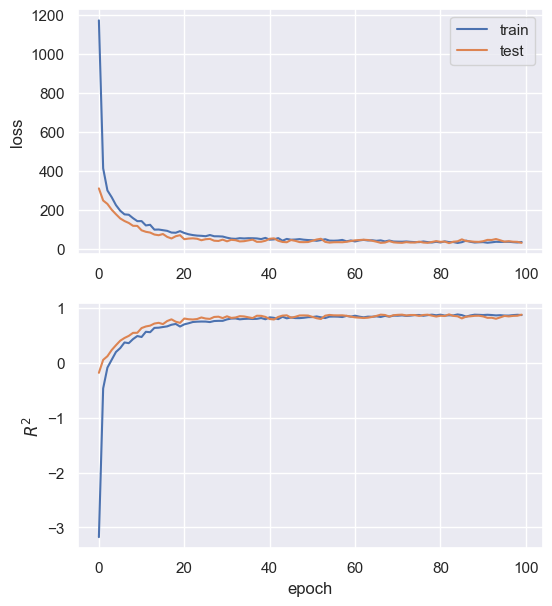

In [409]:
plot(train_losses, train_r2s, test_losses, test_r2s)

In [411]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)

r2 = metrics.r2_score(y_true, y_pred)
print(f"R^2: {r2:.6f}")

R^2: 0.880721
